In [95]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import torch_explain as te


In [157]:
from functools import wraps
from time import time

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r took: %2.4f sec\n' % 
          (f.__name__, te-ts))
        return result
    return wrap

In [158]:
trainLoader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data', train=True, download=True,
                                 transform=torchvision.transforms.Compose([
                                        torchvision.transforms.ToTensor(),
                                        torchvision.transforms.Normalize(
                                            (0.1307,), (0.3081,))
                                    ])),
    batch_size=128, shuffle=True)


testLoader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data', train=False, download=True,
                                    transform=torchvision.transforms.Compose([
                                        torchvision.transforms.ToTensor(),
                                        torchvision.transforms.Normalize(
                                            (0.1307,), (0.3081,))
                                    ])),
    batch_size=128, shuffle=True)



In [83]:
batch_i, (exampledata, exampletargets) = next(enumerate(testLoader))

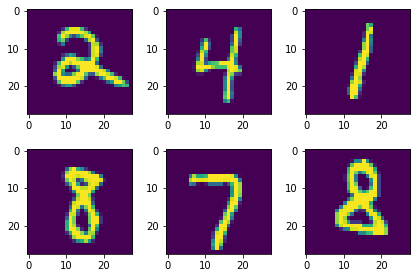

In [84]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(exampledata[i].view(28, 28))

In [147]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1,10, kernel_size=5)
        self.conv2 = nn.Conv2d(10,20, kernel_size=5)
        self.conv_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50,10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training = self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [153]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # GPU
    print("Using GPU")
else:
    device = torch.device("cpu")  # CPU
    print("Using CPU")


net = Net()
net.to(device)
optimizer = optim.SGD(net.parameters(), lr=0.01)

Using GPU


In [154]:
print(net)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [159]:
train_losses = []

@timing
def train(epoch):
    net.train()
    for index, (data, target) in tqdm(enumerate(trainLoader)):
        data = data.float()
        data = data.to(device)
        # print(data.type())
        # target = target.float()
        target = target.to(device)
        optimizer.zero_grad()
        output = net(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        # if index % 50 == 0:
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        # epoch, index * len(data), len(trainLoader.dataset),
        # 100. * index / len(trainLoader), loss.item()))

        train_losses.append(loss.item())
        # torch.save(net.state_dict(), "/results/model.pth")
        # torch.save(optimizer.state_dict(), "/results/optimizer.pth")

In [151]:
train(5)

# print(train_losses)

0it [00:00, ?it/s]C:\Users\benma\AppData\Local\Temp/ipykernel_5980/1576475065.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
469it [00:17, 27.10it/s]

func:'train' took: 17.3089 sec


In [90]:
def test():
    net.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in testLoader:
            data = data.to(device)
            target = target.to(device)
            output = [int(torch.argmax(x)) for x in net(data)]
            target = [int(x) for x in target]
            same = sum(np.equal(output, target))
            # print(output, target)
            print("Same: {}".format(same))
            break

In [91]:
test()

Same: 109


C:\Users\benma\AppData\Local\Temp/ipykernel_5980/1576475065.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [156]:
test()
for epoch in range(5):
    train(epoch)
    test()

C:\Users\benma\AppData\Local\Temp/ipykernel_5980/1576475065.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Same: 27


469it [00:16, 28.89it/s]


func:'train' took: 16.2411 sec
Same: 113


469it [00:14, 31.81it/s]


func:'train' took: 14.7478 sec
Same: 113


469it [00:14, 33.20it/s]


func:'train' took: 14.1307 sec
Same: 115


469it [00:13, 33.79it/s]


func:'train' took: 13.8830 sec
Same: 121


469it [00:15, 29.97it/s]

func:'train' took: 15.6553 sec
Same: 120


In [160]:
from torch_explain.logic.nn import psi

In [165]:
for data, target in testLoader:
    print(psi.explain_class(net.to('cpu'), target))
    break

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [93]:
with torch.cuda.device(0):
    # allocates a tensor on GPU 1
    a = torch.tensor([1., 2.], device=torch.device('cuda'))

    # transfers a tensor from CPU to GPU 1
    b = torch.tensor([1., 2.]).cuda()
    # a.device and b.device are device(type='cuda', index=1)

In [19]:
torch.cuda.is_available()

True

In [20]:
print(torch.device("cuda:0"))

cuda:0


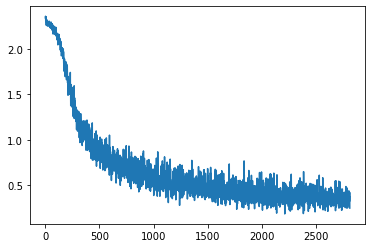

In [94]:
import matplotlib.pyplot as plt

plt.plot(np.linspace(0, len(train_losses), len(train_losses)), train_losses)